In [1]:
import numpy as np
import pandas as pd
import os
import random
import pyarrow
from tensorflow import keras
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
#import sktime

In [2]:
pd.options.display.max_rows=999

In [3]:
raw_data_p = r'/h/dsmith/physionet_data/prepped/physionet_data.parquet'

In [4]:
df = pd.read_parquet(raw_data_p, engine='pyarrow')
df = df.drop_duplicates()

In [5]:
df.shape

(1429854, 43)

In [6]:
df.head(5)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,SepsisEver,id
0,60.0,98.0,36.200,135.0,109.0,72.0,17.0,33.017979,-0.441724,24.382587,...,194.0,57.0,0.0,0.492043,0.507957,-12.02,1.0,0.0,0,27338
1,60.0,98.0,36.200,135.0,109.0,72.0,17.0,33.017979,-0.441724,24.382587,...,194.0,57.0,0.0,0.492043,0.507957,-12.02,2.0,0.0,0,27338
2,56.0,98.0,36.225,127.0,105.0,73.0,15.0,33.017979,-0.441724,24.382587,...,194.0,57.0,0.0,0.492043,0.507957,-12.02,3.0,0.0,0,27338
3,54.0,98.0,36.250,119.0,100.0,76.0,13.0,33.017979,-0.441724,24.382587,...,194.0,57.0,0.0,0.492043,0.507957,-12.02,4.0,0.0,0,27338
4,52.0,98.0,36.275,119.0,87.0,67.0,12.0,33.017979,-0.441724,24.382587,...,194.0,57.0,0.0,0.492043,0.507957,-12.02,5.0,0.0,0,27338


In [7]:
df.id.nunique()

36612

In [8]:
### check for non-static variables. Keep them for later steps
var_mtx = df.groupby('id').agg('var').reset_index(drop=True)
eps = 0
var_keep = list(var_mtx.columns[var_mtx.sum() > eps])

In [9]:
var_keep

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'EtCO2',
 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',
 'ICULOS',
 'SepsisLabel']

Starter Model:
1. use min_len = min(time serires length for subject i, for i = 1,2,..., N) as unified length of input time series
2. keep the last min_len\$th\$ readings of each subject
3. include all non-static variables

In [10]:
#df.groupby('id').apply(lambda x:x.shape[0]).describe([x/10 for x in range(11)])
min_len = df.groupby('id').apply(lambda x:x.shape[0]).min()

In [11]:
print(min_len)

11


In [12]:
#df.groupby('id').apply(lambda x:x.shape[0]).describe()

In [13]:
df_short = df.groupby('id').apply(lambda x:x.tail(min_len))
df_short = df_short.reset_index(drop=True)

In [14]:
df_short.head(20)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,SepsisEver,id
0,89.0,99.0,38.280000,164.00,85.00,57.0,27.0,33.017979,-2.0,18.608696,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,88.0,0.0,1,1
1,88.0,98.0,38.056667,147.00,77.00,51.0,24.0,33.017979,-2.0,18.652174,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,89.0,1.0,1,1
2,84.5,99.0,37.833333,140.50,74.00,50.0,30.0,33.017979,-2.0,18.695652,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,90.0,1.0,1,1
3,83.0,99.5,37.610000,133.50,70.00,49.0,28.0,33.017979,-2.0,18.739130,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,91.0,1.0,1,1
4,88.0,99.0,37.644000,83.75,55.17,48.0,27.0,33.017979,-2.0,18.782609,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,92.0,1.0,1,1
5,87.0,97.0,37.678000,130.00,67.33,54.0,28.0,33.017979,-1.8,18.826087,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,93.0,1.0,1,1
6,90.0,97.0,37.712000,137.00,75.00,51.0,28.0,33.017979,-1.6,18.869565,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,94.0,1.0,1,1
7,90.0,98.0,37.746000,148.50,83.25,55.5,26.0,33.017979,-1.4,18.913043,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,95.0,1.0,1,1
8,90.0,99.0,37.780000,160.00,91.50,60.0,29.5,33.017979,-1.2,18.956522,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,96.0,1.0,1,1
9,82.0,98.0,37.780000,129.00,66.00,43.0,25.0,33.017979,-1.0,19.000000,...,197.0,63.18,0.0,0.492043,0.507957,-0.02,97.0,1.0,1,1


In [18]:
print(x_var)

['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'ICULOS']


In [15]:
x_var = [x for x in var_keep if x!='SepsisLabel']

X = np.array(list(df_short.groupby('id').apply(lambda x:x[x_var].values.tolist())))
y = np.array(df_short.groupby('id').apply(lambda x: 1 if x['SepsisLabel'].sum()>=1 else 0))

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(25628, 11, 35)
(25628,)
(10984, 11, 35)
(10984,)


In [19]:
x_train = x_train.reshape((x_train.shape[0], min_len, len(x_var)))
x_test = x_test.reshape((x_test.shape[0], min_len, len(x_var)))

In [20]:
num_classes = len(np.unique(y_train))

In [21]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [22]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


2022-03-10 15:35:47.538922: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 15:35:48.271584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10675 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:06:00.0, compute capability: 7.5


In [23]:
model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [24]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_test,y_test),
    verbose=1,
)

Epoch 1/500


2022-03-10 15:35:53.607164: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-10 15:35:54.315274: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-10 15:35:54.317247: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-10 15:35:54.317316: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-10 15:35:54.319169: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-10 15:35:54.319425: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


801/801 [==============================] - 8s 5ms/step - loss: 0.1943 - sparse_categorical_accuracy: 0.9430 - val_loss: 0.1712 - val_sparse_categorical_accuracy: 0.9515 - lr: 0.0010
Epoch 2/500
801/801 [==============================] - 4s 5ms/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.1551 - val_sparse_categorical_accuracy: 0.9546 - lr: 0.0010
Epoch 3/500
801/801 [==============================] - 4s 5ms/step - loss: 0.1595 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.1583 - val_sparse_categorical_accuracy: 0.9553 - lr: 0.0010
Epoch 4/500
801/801 [==============================] - 4s 5ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.1464 - val_sparse_categorical_accuracy: 0.9558 - lr: 0.0010
Epoch 5/500
801/801 [==============================] - 4s 5ms/step - loss: 0.1511 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.3214 - val_sparse_categorical_accuracy: 0.9079 - lr: 0.0010
Epoch 6/500
801/801 [=====================

KeyboardInterrupt: 

In [25]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

344/344 [==============================] - 1s 2ms/step - loss: 0.1457 - sparse_categorical_accuracy: 0.9572
Test accuracy 0.9572104811668396
Test loss 0.1456594169139862


In [26]:
model = keras.models.load_model("best_model.h5")

In [27]:
## layers 
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_2
1 conv1d_3
2 batch_normalization_3
3 re_lu_3
4 conv1d_4
5 batch_normalization_4
6 re_lu_4
7 conv1d_5
8 batch_normalization_5
9 re_lu_5
10 global_average_pooling1d_1
11 dense_1


In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 11, 35)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 64)            6784      
                                                                 
 batch_normalization_3 (Batc  (None, 11, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 11, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 11, 64)            12352     
                                                                 
 batch_normalization_4 (Batc  (None, 11, 64)           256       
 hNormalization)                                           

In [29]:
feature_model = Model(inputs=model.inputs, outputs=model.layers[10].output)

In [30]:
feature_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 11, 35)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 64)            6784      
                                                                 
 batch_normalization_3 (Batc  (None, 11, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 11, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 11, 64)            12352     
                                                                 
 batch_normalization_4 (Batc  (None, 11, 64)           256       
 hNormalization)                                           

In [31]:
y_test_pred = feature_model.predict(x_test)

In [33]:
y_test_pred.shape

(10984, 64)

In [34]:
y_test.shape

(10984,)

/ssd003/projects/aieng/public/forecasting_unified_tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified_tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


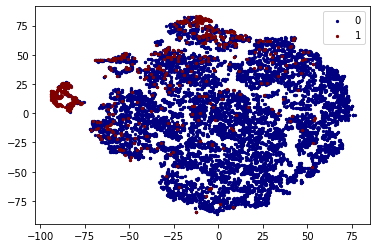

In [39]:
from sklearn import manifold

tsne=manifold.TSNE(n_components=2)
tY=tsne.fit_transform(y_test_pred)

#import matplotlib.pyplot as plt
#plt.scatter(tY[:,0],tY[:,1])
#plt.legend()
#plt.show()
#
#

y_train=np.squeeze(y_test)
import matplotlib.pyplot as plt

classes=np.unique(y_train)

jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,np.size(np.unique(y_train)))))


for i in range(np.size(np.unique(y_train))):
    

    plt.scatter(tY[y_train==classes[i],0],tY[y_train==classes[i],1],color=next(colors),label=str(classes[i]),s=5)
    
plt.legend()